<a href="https://colab.research.google.com/github/toyokawaxyz/forex/blob/main/main__ver10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import  numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from scipy.stats import norm
from sklearn.model_selection import train_test_split,TimeSeriesSplit, GridSearchCV,KFold
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
import seaborn as sns
from sklearn import svm
import keras
from keras import backend as K
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense,SimpleRNN
from sklearn.pipeline import Pipeline
from keras import metrics

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping 
import warnings
warnings.simplefilter('ignore')
# Early-stopping 
nan_monitor= keras.callbacks.TerminateOnNaN()
early_stopping = EarlyStopping(patience=1, verbose=1) 



%matplotlib inline

In [ ]:
EURUSD ="/content/drive/MyDrive/rate/eurusd2000_2019august_all.csv"
USDJPY ="/content/drive/MyDrive/rate/usdjpy2000_2019august_all.csv"
GBPUSD ="/content/drive/MyDrive/rate/gbpusd2000_2019august_all.csv"
USDCHF ="/content/drive/MyDrive/rate/usdchf2000_2019august_all.csv"
AUDUSD ="/content/drive/MyDrive/rate/audusd2000_2019august_all.csv"
USDCAD ="/content/drive/MyDrive/rate/usdcad2000_2019august_all.csv"

In [ ]:

model_list= ["MLP","RF","SVM"]


In [ ]:
from google.colab import files
table_rmse_paper = pd.DataFrame(index=["MLP_tanh","MLP_relu","MLP_sigmoid","RF","SVM"] , columns=["EURUSD","USDJPY","USDCHF","GBPUSD","USDCAD","AUDUSD"])
table_mae_paper = pd.DataFrame(index=["MLP_tanh","MLP_relu","MLP_sigmoid","RF","SVM"] , columns=["EURUSD","USDJPY","USDCHF","GBPUSD","USDCAD","AUDUSD"])
table_rmse_paper["EURUSD"]= [0.015,0.0064,0.0062,0.0068,0.0332]
table_rmse_paper["USDJPY"] = [1.2248,0.9711,1.1372,0.6781,0.6387]
table_rmse_paper["USDCHF"] = [0.0138,0.0081,0.018,0.0081,0.0394]
table_rmse_paper["GBPUSD"] = [0.0372,0.0217,0.0181,0.0244,0.0329]
table_rmse_paper["USDCAD"] = [0.0211,0.0066,0.0078,0.0075,0.0125]
table_rmse_paper["AUDUSD"] = [0.0129,0.0048,0.008,0.0056,0.02]
table = table_rmse_paper.to_csv("/content/drive/MyDrive/rate/table_rmse_paper.csv")

table_mae_paper["EURUSD"]= [0.012,0.0049,0.0046,0.0053,0.0304]
table_mae_paper["USDJPY"] = [0.9754,0.7499,0.9013,0.5209,0.4718]
table_mae_paper["USDCHF"] = [0.009,0.0058,0.0156,0.0061,0.0376]
table_mae_paper["GBPUSD"] = [0.0246,0.015,0.012,0.0156,0.0294]
table_mae_paper["USDCAD"] = [0.0176,0.0052,0.0063,0.0059,0.0099]
table_mae_paper["AUDUSD"] = [0.01,0.0038,0.0069,0.0044,0.0176]
table_mae_paper.to_csv("/content/drive/MyDrive/rate/table_mae_paper.csv")
#table読み込み
df_table_rmse_paper = pd.read_csv("/content/drive/MyDrive/rate/table_rmse_paper.csv",index_col=0)
df_table_mae_paper = pd.read_csv("/content/drive/MyDrive/rate/table_mae_paper.csv",index_col=0)
df_table_mae_paper

,EURUSD,USDJPY,USDCHF,GBPUSD,USDCAD,AUDUSD
MLP_tanh,0.0120,0.9754,0.0090,0.0246,0.0176,0.0100
MLP_relu,0.0049,0.7499,0.0058,0.0150,0.0052,0.0038
MLP_sigmoid,0.0046,0.9013,0.0156,0.0120,0.0063,0.0069
RF,0.0053,0.5209,0.0061,0.0156,0.0059,0.0044
SVM,0.0304,0.4718,0.0376,0.0294,0.0099,0.0176


In [ ]:
lambda_ = 0.94   #モルガンスタンレーが採用しているEWMAに用いる重みの定数
alpha = 0.95    #標準正規分布の有効範囲のパラメータ 0.95なら95%点

#2 データの記述統計、前処理、調整、テストで関数を分けておいた方が、後に一部変更が発生したときに対処しやすい


 #---------------------------------------------------------前処理--------------------------- 
def Preprocessing(data):
  data = pd.read_csv(data,names=("Results","High","Low","Close"),skiprows=8)
  train= data[:-365]
  test=data[-365:]
  test.reset_index(inplace=True, drop=True)
  #-------------------------------記述統計----------------------------------------
  print("---------------------------traindata_記述統計-------------------------------------------------------------\n",train.describe())
  print("----------------------------testdata_記述統計-------------------------------------------------------\n",test.describe())
  print("--------------------(正規化前_shape)-----------------------------------------------\n","train.shape:",train.shape,"test.shape:",test.shape)

  #VaR計算用に終値を代入(t=train data,   k = test data)
  close_t = train["Close"]
  close_k = test["Close"]

  #-------------------------------------------正規化のための計算-----------------
  # rの算出
  train["r"] = None
  for t in range(1,len(close_t)):
    train["r"][t] =np.log(close_t[t]/close_t[t-1])
  #（1）式により出たNoneが含まれている行を除外  つまりは最初の1行を除外
  train =train.dropna(subset=["r"])
  print(train.shape)

  r_ = sum(train["r"])/len(train["r"])   #r_の算出(つまりはr_iの平均)
  #σ^2の算出
  s2 =sum((train["r"]- r_)**2) /len(train["r"])       
  train["s2"] =s2
  # r_t == r_i[-1]
  train["r_t"] = None
  r_t= train["r"][-1:]
  train["r_t"]= train["r_t"].where(train["r_t"]==all, r_t.values)
  #σ^2（t+1）　＝（1-λ）*r^2 + λ*σ^2
  train["s2_tplus1"] = (1-lambda_) * train["r_t"]**2  + lambda_*s2 
  # φ^-1
  phi_inverse =norm.ppf(alpha)    
  var_tplus1 = (train["s2_tplus1"]**0.5)* phi_inverse     #VaR_(t+1) = σ^2_(t+1) * φ^(-1) , α=0.99 
  train["var_tplus1"]   = var_tplus1
  #VaR_(t+k) = VaR_(t+1) * √k   /高値 , k= （テストデータの長さ)
  var_tplusk = (var_tplus1) * (len(test)**0.5) 

  #max_(t+k)   = y_t * { 1 + var_(t+k)} 
  y_t= train["Close"][-1:].values
  max_tplusk = y_t * (1+ var_tplusk)
  #min_(t+k)
  min_tplusk = y_t * (1- var_tplusk)

  #Max_(global)
  max_y = max(train["High"])
  max_var = max(max_tplusk)
  max_global =max(max_var, max_y)
  #Min_(global)
  min_y = min(train["Low"])
  min_var = min(min_tplusk)
  min_global= min(min_var, min_y)

  #y'_(i) = {y_(i) - Min_(global)}/{Max_(global) - Min_(global)}
  y_i_dash = (train["Close"] - min_global)   / (max_global - min_global)   
  train["y_i_dash"] = y_i_dash
  #y'_(j) = {y_(j) - Min_(global)}/{Max_(global) - Min_(global)}
  y_j_dash = (test["Close"] - min_global)   / (max_global - min_global)  
  test["y_j_dash"] = y_j_dash
  #------------------------------正規化したデータの訓練etc.------------------------------------------
  data_train = pd.DataFrame()
  data_train["time"] = train["Results"]
  data_train["value"]  = train["y_i_dash"]
  data_train["lag_1"]  = train["y_i_dash"].shift(1)
  data_train["lag_2"]  = train["y_i_dash"].shift(2)
  data_train["lag_3"]  = train["y_i_dash"].shift(3)
  data_train["lag_4"]  = train["y_i_dash"].shift(4)
  data_train["lag_5"]  = train["y_i_dash"].shift(5)
  data_train = data_train.dropna()
  data_train.reset_index(inplace=True, drop=True)

  data_test= pd.DataFrame()
  data_test["time"] = test["Results"]
  data_test["value"] = test["y_j_dash"]
  data_test["lag_1"] = test["y_j_dash"].shift(1)
  data_test["lag_2"] = test["y_j_dash"].shift(2)
  data_test["lag_3"] = test["y_j_dash"].shift(3)
  data_test["lag_4"] = test["y_j_dash"].shift(4)
  data_test["lag_5"] = test["y_j_dash"].shift(5)
  data_test = data_test.dropna()
  data_test.reset_index(inplace=True, drop=True)
  #-----------------------------------------------------------------------------------
  #--------train data , test data---------------------------------------------
  X_train = data_train[["lag_1", "lag_2", "lag_3", "lag_4","lag_5"]].values
  y_train =data_train["value"].values

  X_test =data_test[["lag_1", "lag_2", "lag_3", "lag_4","lag_5"]].values
  y_test= data_test["value"].values
  #------------------------testのx軸-------------------------------------------------------------
  time_test = pd.DataFrame()
  time_test =data_test["time"]

  """
  #--------------------------cross validation--------
  kf = KFold(n_splits=5, shuffle=True)

  for train_index, eval_index in kf.split(X_train):
    X_tra, X_eval = X_train[train_index], X_train[eval_index]
    y_tra, y_eval = y_train[train_index], y_train[eval_index]
  print(X_tra,X_eval)
  """


  return X_train,X_test, y_train,y_test,min_global,max_global , test, time_test

  #-------------------------------------正規化したデータの復元-----------------------------------------------------------------
def repair(min_global,max_global, y_test_pred):
  #正規化されている予測データを戻す(テストデータ) 
  y_j = min_global + y_test_pred * (max_global - min_global)
  return y_j




#RMSE定義
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))
    


#-------------------------------------結果 plot---------------------------------------------------- 
def result(test,y_j,time_test):
  
  ticks = 30
  plt.xticks(rotation=90)
  plt.xticks(range(0, len(time_test), ticks), time_test[::ticks])

  plt.plot(test["Close"][5:],label="actual")
  plt.plot(y_j,label="predict")
  plt.legend()  
  plt.show()
  
  

  rmse = np.sqrt(mean_squared_error(test["Close"][5:] ,y_j))
  print('RMSE : {:.5f}'.format(rmse))
  mae = mean_absolute_error(test["Close"][5:] ,y_j)
  print('MAE : {:.5f}'.format(mae))
  
  return rmse,mae
  



#---------------------------------NN パラメータ等--------------------------------------
n_in = 5  # 入力層のニューロン数
n_mid = 16  # 中間層のニューロン数
n_out = 1  # 出力層のニューロン数


#--------------------------------------MLP------------------------------------------------------------------
def MLP(X_train,X_test,y_train,y_test,function):
  print("MLP:",function)
  # 入力層、中間層、出力層の３層のニューラルネットワークを構築する
  model = Sequential()
  model.add(Dense(n_mid, input_shape=(n_in,), activation=function))  
  model.add(Dense(n_out, activation="linear"))  
  model.compile(loss = root_mean_squared_error, optimizer= keras.optimizers.Adam(learning_rate=0.01))  
  

  #学習開始
  history =model.fit( X_train , y_train,batch_size=64 ,epochs=3000, validation_split=0.2, verbose=0,callbacks=[early_stopping,nan_monitor]) 
  #pd.DataFrame(history.history).plot()

  y_test_pred = model.predict(X_test)
  
  
  return y_test_pred


#--------------------------------------------FOREX-----------------------------------




def forex(model_select,data):
  

  X_train,X_test, y_train,y_test, min_global,max_global,test, time_test = Preprocessing(data)



  if model_select in {"MLP"}:
    functions =("tanh","relu","sigmoid")
    #functions =("tanh",)
    for function in functions:

      y_test_pred =MLP(X_train,X_test,y_train,y_test,function)
      y_j = repair(min_global,max_global,y_test_pred)
      rmse,mae=result(test,y_j,time_test)
      #print("after result:  rmse,mae",function,rmse,mae)


      if function in {"tanh"}:
        global rmse_list_mlp_tanh,mae_list_mlp_tanh
        rmse_list_mlp_tanh.append(rmse)
        mae_list_mlp_tanh.append(mae)

        print("rmse_list_mlp_tanh------------------------",rmse_list_mlp_tanh)
        print("mae_list_mlp_tanh------------------------",mae_list_mlp_tanh)
        print("rmse_list_length",len(rmse_list_mlp_tanh))

        #table_loss(rmse_list_mlp_tanh,mae_list_mlp_tanh)
      elif function in {"relu"}:
        global rmse_list_mlp_relu,mae_list_mlp_relu
        rmse_list_mlp_relu.append(rmse)
        mae_list_mlp_relu.append(mae)

        print("rmse_list_mlp_relu------------------------",rmse_list_mlp_relu)
        print("mae_list_mlp_relu------------------------",mae_list_mlp_relu)
        print("rmse_list_length",len(rmse_list_mlp_relu))
        #table_loss(rmse_list_mlp_relu,mae_list_mlp_relu)

        

      elif function in {"sigmoid"}:
        global rmse_list_mlp_sigmoid,mae_list_mlp_sigmoid
        rmse_list_mlp_sigmoid.append(rmse)
        mae_list_mlp_sigmoid.append(mae)

        print("rmse_list_mlp_sigmoid------------------------",rmse_list_mlp_sigmoid)
        print("mae_list_mlp_sigmoid------------------------",mae_list_mlp_sigmoid)
        print("rmse_list_length",len(rmse_list_mlp_sigmoid))
        #table_loss(rmse_list_mlp_sigmoid,mae_list_mlp_sigmoid)
        


      


  elif model_select in {"SVM"}:
    global rmse_list_svm,mae_list_svm

    y_test_pred = SVM(X_train,X_test,y_train)
    y_j = repair(min_global,max_global,y_test_pred)
    rmse,mae=result(test,y_j,time_test)
    print("after result:  rmse,mae",rmse,mae)
    rmse_list_svm.append(rmse)
    mae_list_svm.append(mae)
    #sorted(list(set(rmse_list_svm)),key=rmse_list_svm.index)
    #sorted(list(set(mae_list_svm)),key=mae_list_svm.index)

    print("rmse_list_svm------------------------",rmse_list_svm)
    print("mae_list_svm------------------------",mae_list_svm)
    print("rmse_list_length",len(rmse_list_svm))
    

  elif model_select in {"RF"}:
    global rmse_list_rf,mae_list_rf
    y_test_pred = RF(X_train,X_test,y_train)
    y_j = repair(min_global,max_global,y_test_pred)
    rmse,mae=result(test,y_j,time_test)
    print("after result:  rmse,mae",rmse,mae)

    rmse_list_rf.append(rmse)
    mae_list_rf.append(mae)
    sorted(list(set(rmse_list_rf)),key=rmse_list_rf.index)
    sorted(list(set(mae_list_rf)),key=mae_list_rf.index)

    print("rmse_list_rf------------------------",rmse_list_rf)
    print("mae_list_rf------------------------",mae_list_rf)
    print("rmse_list_length",len(rmse_list_rf))



  return rmse,mae



df_rmse = pd.DataFrame()
df_mae = pd.DataFrame()
def table_loss(model_select,forex_str,rmse,mae):
  df_rmse[[model_select][forex_str]] = rmse
  df_mae[[model_select][forex_str]] = mae



  

#--------------------------------パラメータチューニング---------------------------




def RF(X_train,X_test,y_train):
  print("RF_gridsearch")
  n_estimators= [500,1500,3000]
  max_depth=[2,5,8]

  param_grid = dict(n_estimators=n_estimators,max_depth=max_depth)
  RF= RandomForestRegressor()
  grid= GridSearchCV(RF,param_grid=param_grid,cv=5,n_jobs=-1,refit=True)
  grid.fit(X_train,y_train)
  y_test_pred = grid.predict(X_test)
  #print(grid_cv.best_params_)
  #print(grid_cv.best_score_)
  
  return y_test_pred


def SVM(X_train,X_test,y_train):
  print("SVM_gridsearch")

  Cs= [100,300,500,700,900]
  gammas=[0.001,0.002,0.003,0.004]
  param_grid = dict(gamma=gammas,C=Cs)
  
  SVR_model = svm.SVR()
  grid= GridSearchCV(SVR_model,param_grid=param_grid,cv=5,n_jobs=-1,refit=True)
  
  grid.fit(X_train,y_train)
  print(grid.best_params_)


  y_test_pred = grid.predict(X_test)
  #print(grid_cv.best_params_)
  #print(grid_cv.best_score_)
  
  return y_test_pred


/content/drive/MyDrive/rate/eurusd2000_2019august_all.csv
---------------------------traindata_記述統計-------------------------------------------------------------
               High          Low        Close
count  4765.000000  4765.000000  4765.000000
mean      1.216274     1.221832     1.210633
std       0.172503     0.173137     0.171871
min       0.827600     0.832100     0.822800
25%       1.105000     1.111140     1.099670
50%       1.244800     1.250800     1.238500
75%       1.339500     1.344500     1.334200
max       1.599700     1.604000     1.586600
----------------------------testdata_記述統計-------------------------------------------------------
              High         Low       Close
count  365.000000  365.000000  365.000000
mean     1.145687    1.149526    1.142457
std      0.027167    0.027575    0.026661
min      1.097500    1.106100    1.096300
25%      1.126200    1.128800    1.123600
50%      1.138000    1.142100    1.135200
75%      1.162600    1.166500    1.157000

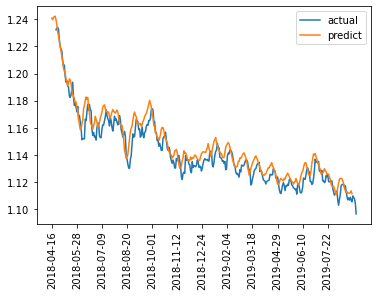

RMSE : 0.00893
MAE : 0.00735
rmse_list_mlp_tanh------------------------ [0.008926197251179015]
mae_list_mlp_tanh------------------------ [0.00735449131774902]
rmse_list_length 1
MLP: relu
Epoch 00006: early stopping


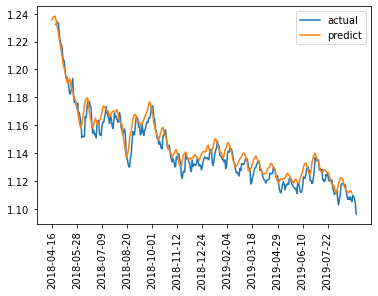

RMSE : 0.00810
MAE : 0.00663
rmse_list_mlp_relu------------------------ [0.00809710101945936]
mae_list_mlp_relu------------------------ [0.006633964198112483]
rmse_list_length 1
MLP: sigmoid
Epoch 00002: early stopping


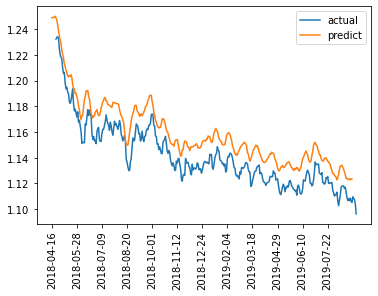

RMSE : 0.01911
MAE : 0.01799
rmse_list_mlp_sigmoid------------------------ [0.01911270793843243]
mae_list_mlp_sigmoid------------------------ [0.017990469496197165]
rmse_list_length 1
/content/drive/MyDrive/rate/usdjpy2000_2019august_all.csv
---------------------------traindata_記述統計-------------------------------------------------------------
               High          Low        Close
count  4765.000000  4765.000000  4765.000000
mean    106.271742   106.751620   105.768978
std      13.775231    13.808399    13.733553
min      75.720000    76.000000    75.550000
25%      98.240000    98.850000    97.640000
50%     108.720000   109.182000   108.250000
75%     117.530000   117.960000   117.020000
max     134.780000   135.150000   134.100000
----------------------------testdata_記述統計-------------------------------------------------------
             High         Low       Close
count  365.00000  365.000000  365.000000
mean   110.30411  110.604164  109.961973
std      2.00546    1.989408

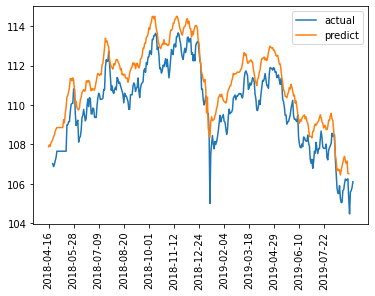

RMSE : 1.33344
MAE : 1.15324
rmse_list_mlp_tanh------------------------ [0.008926197251179015, 1.3334438533501833]
mae_list_mlp_tanh------------------------ [0.00735449131774902, 1.1532385626898878]
rmse_list_length 2
MLP: relu
Epoch 00004: early stopping


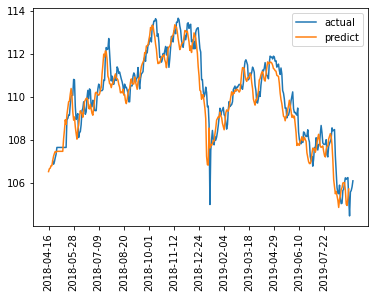

RMSE : 0.55626
MAE : 0.43067
rmse_list_mlp_relu------------------------ [0.00809710101945936, 0.5562642117215797]
mae_list_mlp_relu------------------------ [0.006633964198112483, 0.43067133416069847]
rmse_list_length 2
MLP: sigmoid
Epoch 00002: early stopping


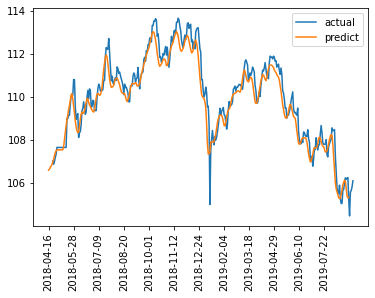

RMSE : 0.70975
MAE : 0.56292
rmse_list_mlp_sigmoid------------------------ [0.01911270793843243, 0.7097491688926606]
mae_list_mlp_sigmoid------------------------ [0.017990469496197165, 0.5629240137735999]
rmse_list_length 2
/content/drive/MyDrive/rate/usdchf2000_2019august_all.csv
---------------------------traindata_記述統計-------------------------------------------------------------
               High          Low        Close
count  4765.000000  4765.000000  4765.000000
mean      1.164827     1.170758     1.159192
std       0.255012     0.256483     0.253664
min       0.718000     0.732300     0.708500
25%       0.962300     0.966600     0.957600
50%       1.084000     1.090000     1.076300
75%       1.284500     1.291700     1.277500
max       1.820300     1.829500     1.812800
----------------------------testdata_記述統計-------------------------------------------------------
              High         Low       Close
count  365.000000  365.000000  365.000000
mean     0.991688    0.9946

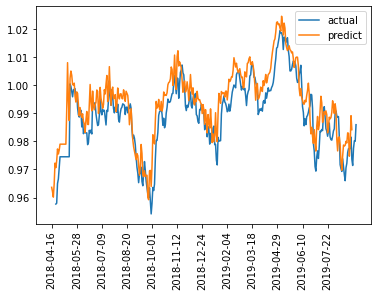

RMSE : 0.00656
MAE : 0.00540
rmse_list_mlp_tanh------------------------ [0.008926197251179015, 1.3334438533501833, 0.006564235668753824]
mae_list_mlp_tanh------------------------ [0.00735449131774902, 1.1532385626898878, 0.005401485726833339]
rmse_list_length 3
MLP: relu
Epoch 00006: early stopping


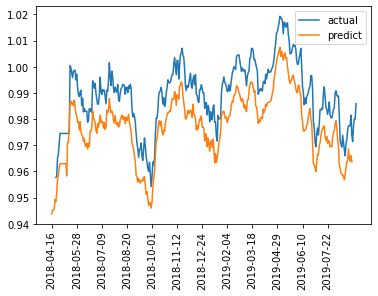

RMSE : 0.01379
MAE : 0.01227
rmse_list_mlp_relu------------------------ [0.00809710101945936, 0.5562642117215797, 0.013793927280796436]
mae_list_mlp_relu------------------------ [0.006633964198112483, 0.43067133416069847, 0.012273396103911935]
rmse_list_length 3
MLP: sigmoid
Epoch 00002: early stopping


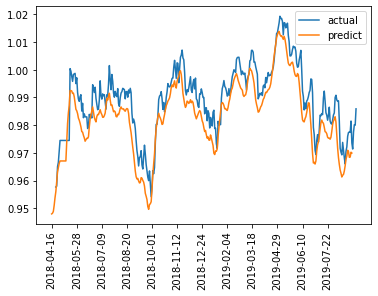

RMSE : 0.00848
MAE : 0.00709
rmse_list_mlp_sigmoid------------------------ [0.01911270793843243, 0.7097491688926606, 0.008479530717750972]
mae_list_mlp_sigmoid------------------------ [0.017990469496197165, 0.5629240137735999, 0.0070881022440062716]
rmse_list_length 3
/content/drive/MyDrive/rate/gbpusd2000_2019august_all.csv
---------------------------traindata_記述統計-------------------------------------------------------------
               High         Low        Close
count  4765.000000  4765.00000  4765.000000
mean      1.615163     1.62185     1.608280
std       0.194189     0.19453     0.194032
min       1.205410     1.20853     1.152240
25%       1.482600     1.49300     1.474500
50%       1.587100     1.59190     1.580500
75%       1.745800     1.75300     1.738400
max       2.108500     2.11600     2.097400
----------------------------testdata_記述統計-------------------------------------------------------
              High         Low       Close
count  365.000000  365.000000  36

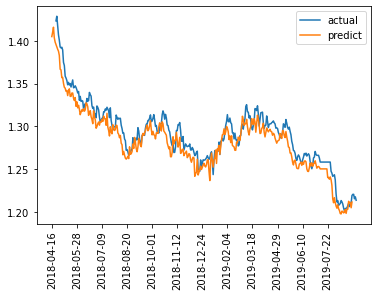

RMSE : 0.01015
MAE : 0.00842
rmse_list_mlp_tanh------------------------ [0.008926197251179015, 1.3334438533501833, 0.006564235668753824, 0.010149469477929326]
mae_list_mlp_tanh------------------------ [0.00735449131774902, 1.1532385626898878, 0.005401485726833339, 0.008424629115316601]
rmse_list_length 4
MLP: relu
Epoch 00004: early stopping


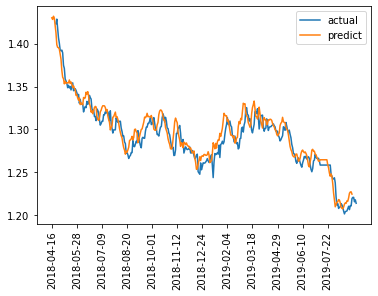

RMSE : 0.00976
MAE : 0.00811
rmse_list_mlp_relu------------------------ [0.00809710101945936, 0.5562642117215797, 0.013793927280796436, 0.009755446881559384]
mae_list_mlp_relu------------------------ [0.006633964198112483, 0.43067133416069847, 0.012273396103911935, 0.008112694865332707]
rmse_list_length 4
MLP: sigmoid
Epoch 00002: early stopping


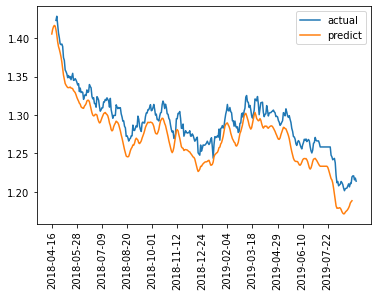

RMSE : 0.02212
MAE : 0.01961
rmse_list_mlp_sigmoid------------------------ [0.01911270793843243, 0.7097491688926606, 0.008479530717750972, 0.022116586025332934]
mae_list_mlp_sigmoid------------------------ [0.017990469496197165, 0.5629240137735999, 0.0070881022440062716, 0.01960957916641235]
rmse_list_length 4
/content/drive/MyDrive/rate/usdcad2000_2019august_all.csv
---------------------------traindata_記述統計-------------------------------------------------------------
              High          Low        Close
count  4765.00000  4765.000000  4765.000000
mean      1.22207     1.227082     1.217288
std       0.18817     0.188324     0.188121
min       0.92290     0.930600     0.906100
25%       1.04730     1.051600     1.042000
50%       1.20680     1.213230     1.199770
75%       1.33849     1.343390     1.333300
max       1.61160     1.619400     1.611000
----------------------------testdata_記述統計-------------------------------------------------------
              High         Low   

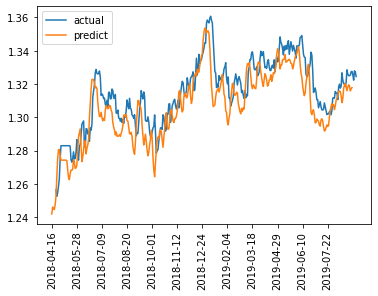

RMSE : 0.01008
MAE : 0.00887
rmse_list_mlp_tanh------------------------ [0.008926197251179015, 1.3334438533501833, 0.006564235668753824, 0.010149469477929326, 0.010077553395044467]
mae_list_mlp_tanh------------------------ [0.00735449131774902, 1.1532385626898878, 0.005401485726833339, 0.008424629115316601, 0.008868247483571364]
rmse_list_length 5
MLP: relu
Epoch 00002: early stopping


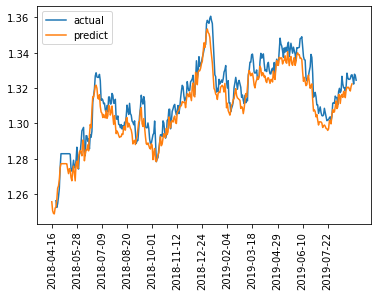

RMSE : 0.00942
MAE : 0.00760
rmse_list_mlp_relu------------------------ [0.00809710101945936, 0.5562642117215797, 0.013793927280796436, 0.009755446881559384, 0.009415787967498711]
mae_list_mlp_relu------------------------ [0.006633964198112483, 0.43067133416069847, 0.012273396103911935, 0.008112694865332707, 0.007595312426249179]
rmse_list_length 5
MLP: sigmoid
Epoch 00004: early stopping


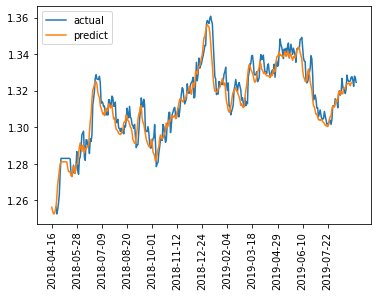

RMSE : 0.00682
MAE : 0.00528
rmse_list_mlp_sigmoid------------------------ [0.01911270793843243, 0.7097491688926606, 0.008479530717750972, 0.022116586025332934, 0.006816148792442755]
mae_list_mlp_sigmoid------------------------ [0.017990469496197165, 0.5629240137735999, 0.0070881022440062716, 0.01960957916641235, 0.005277040467898042]
rmse_list_length 5
/content/drive/MyDrive/rate/audusd2000_2019august_all.csv
---------------------------traindata_記述統計-------------------------------------------------------------
               High          Low        Close
count  4765.000000  4765.000000  4765.000000
mean      0.786372     0.790534     0.781894
std       0.153709     0.154376     0.153002
min       0.483800     0.487200     0.478500
25%       0.702800     0.707200     0.698270
50%       0.769400     0.772700     0.765300
75%       0.907700     0.913600     0.902400
max       1.101800     1.108000     1.097700
----------------------------testdata_記述統計------------------------------------

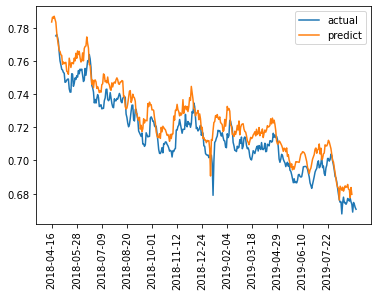

RMSE : 0.01134
MAE : 0.01019
rmse_list_mlp_tanh------------------------ [0.008926197251179015, 1.3334438533501833, 0.006564235668753824, 0.010149469477929326, 0.010077553395044467, 0.011344725483757104]
mae_list_mlp_tanh------------------------ [0.00735449131774902, 1.1532385626898878, 0.005401485726833339, 0.008424629115316601, 0.008868247483571364, 0.010191585062291885]
rmse_list_length 6
MLP: relu
Epoch 00005: early stopping


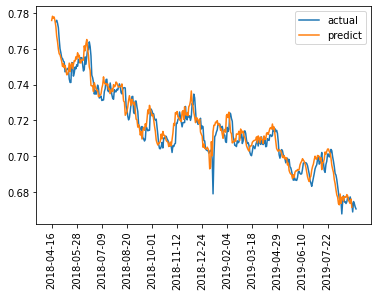

RMSE : 0.00511
MAE : 0.00394
rmse_list_mlp_relu------------------------ [0.00809710101945936, 0.5562642117215797, 0.013793927280796436, 0.009755446881559384, 0.009415787967498711, 0.005111984460259283]
mae_list_mlp_relu------------------------ [0.006633964198112483, 0.43067133416069847, 0.012273396103911935, 0.008112694865332707, 0.007595312426249179, 0.003936765586164261]
rmse_list_length 6
MLP: sigmoid
Epoch 00002: early stopping


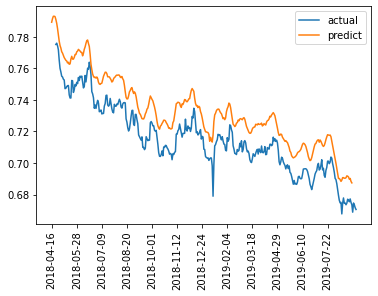

RMSE : 0.01874
MAE : 0.01786
rmse_list_mlp_sigmoid------------------------ [0.01911270793843243, 0.7097491688926606, 0.008479530717750972, 0.022116586025332934, 0.006816148792442755, 0.018744544472594302]
mae_list_mlp_sigmoid------------------------ [0.017990469496197165, 0.5629240137735999, 0.0070881022440062716, 0.01960957916641235, 0.005277040467898042, 0.01786218285518222]
rmse_list_length 6
/content/drive/MyDrive/rate/eurusd2000_2019august_all.csv
---------------------------traindata_記述統計-------------------------------------------------------------
               High          Low        Close
count  4765.000000  4765.000000  4765.000000
mean      1.216274     1.221832     1.210633
std       0.172503     0.173137     0.171871
min       0.827600     0.832100     0.822800
25%       1.105000     1.111140     1.099670
50%       1.244800     1.250800     1.238500
75%       1.339500     1.344500     1.334200
max       1.599700     1.604000     1.586600
----------------------------testda

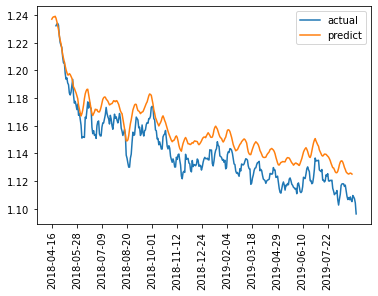

RMSE : 0.01704
MAE : 0.01597
after result:  rmse,mae 0.017037758876757868 0.01596586597664193
rmse_list_svm------------------------ [0.017037758876757868]
mae_list_svm------------------------ [0.01596586597664193]
rmse_list_length 1
/content/drive/MyDrive/rate/usdjpy2000_2019august_all.csv
---------------------------traindata_記述統計-------------------------------------------------------------
               High          Low        Close
count  4765.000000  4765.000000  4765.000000
mean    106.271742   106.751620   105.768978
std      13.775231    13.808399    13.733553
min      75.720000    76.000000    75.550000
25%      98.240000    98.850000    97.640000
50%     108.720000   109.182000   108.250000
75%     117.530000   117.960000   117.020000
max     134.780000   135.150000   134.100000
----------------------------testdata_記述統計-------------------------------------------------------
             High         Low       Close
count  365.00000  365.000000  365.000000
mean   110.30411  11

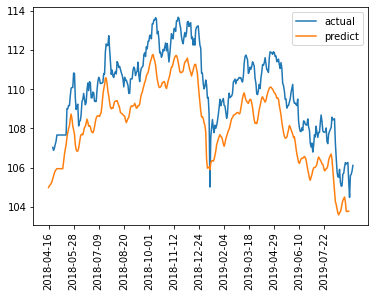

RMSE : 1.82989
MAE : 1.74833
after result:  rmse,mae 1.8298857037932832 1.748325544784948
rmse_list_svm------------------------ [0.017037758876757868, 1.8298857037932832]
mae_list_svm------------------------ [0.01596586597664193, 1.748325544784948]
rmse_list_length 2
/content/drive/MyDrive/rate/usdchf2000_2019august_all.csv
---------------------------traindata_記述統計-------------------------------------------------------------
               High          Low        Close
count  4765.000000  4765.000000  4765.000000
mean      1.164827     1.170758     1.159192
std       0.255012     0.256483     0.253664
min       0.718000     0.732300     0.708500
25%       0.962300     0.966600     0.957600
50%       1.084000     1.090000     1.076300
75%       1.284500     1.291700     1.277500
max       1.820300     1.829500     1.812800
----------------------------testdata_記述統計-------------------------------------------------------
              High         Low       Close
count  365.000000  365.00

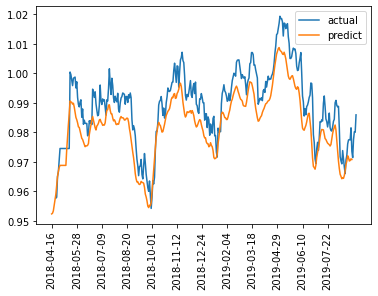

RMSE : 0.00889
MAE : 0.00768
after result:  rmse,mae 0.008885137620642483 0.007681073730412137
rmse_list_svm------------------------ [0.017037758876757868, 1.8298857037932832, 0.008885137620642483]
mae_list_svm------------------------ [0.01596586597664193, 1.748325544784948, 0.007681073730412137]
rmse_list_length 3
/content/drive/MyDrive/rate/gbpusd2000_2019august_all.csv
---------------------------traindata_記述統計-------------------------------------------------------------
               High         Low        Close
count  4765.000000  4765.00000  4765.000000
mean      1.615163     1.62185     1.608280
std       0.194189     0.19453     0.194032
min       1.205410     1.20853     1.152240
25%       1.482600     1.49300     1.474500
50%       1.587100     1.59190     1.580500
75%       1.745800     1.75300     1.738400
max       2.108500     2.11600     2.097400
----------------------------testdata_記述統計-------------------------------------------------------
              High         L

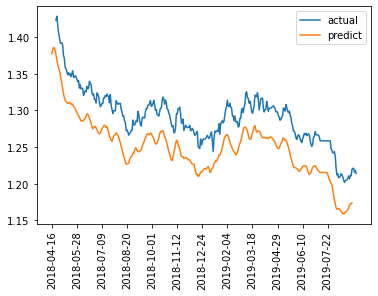

RMSE : 0.04112
MAE : 0.04019
after result:  rmse,mae 0.04112304477502783 0.04019475348711377
rmse_list_svm------------------------ [0.017037758876757868, 1.8298857037932832, 0.008885137620642483, 0.04112304477502783]
mae_list_svm------------------------ [0.01596586597664193, 1.748325544784948, 0.007681073730412137, 0.04019475348711377]
rmse_list_length 4
/content/drive/MyDrive/rate/usdcad2000_2019august_all.csv
---------------------------traindata_記述統計-------------------------------------------------------------
              High          Low        Close
count  4765.00000  4765.000000  4765.000000
mean      1.22207     1.227082     1.217288
std       0.18817     0.188324     0.188121
min       0.92290     0.930600     0.906100
25%       1.04730     1.051600     1.042000
50%       1.20680     1.213230     1.199770
75%       1.33849     1.343390     1.333300
max       1.61160     1.619400     1.611000
----------------------------testdata_記述統計--------------------------------------------

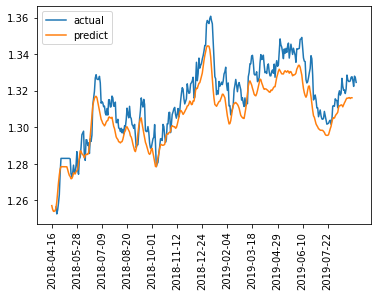

RMSE : 0.01141
MAE : 0.00973
after result:  rmse,mae 0.01141058527828195 0.00972531698322326
rmse_list_svm------------------------ [0.017037758876757868, 1.8298857037932832, 0.008885137620642483, 0.04112304477502783, 0.01141058527828195]
mae_list_svm------------------------ [0.01596586597664193, 1.748325544784948, 0.007681073730412137, 0.04019475348711377, 0.00972531698322326]
rmse_list_length 5
/content/drive/MyDrive/rate/audusd2000_2019august_all.csv
---------------------------traindata_記述統計-------------------------------------------------------------
               High          Low        Close
count  4765.000000  4765.000000  4765.000000
mean      0.786372     0.790534     0.781894
std       0.153709     0.154376     0.153002
min       0.483800     0.487200     0.478500
25%       0.702800     0.707200     0.698270
50%       0.769400     0.772700     0.765300
75%       0.907700     0.913600     0.902400
max       1.101800     1.108000     1.097700
----------------------------testda

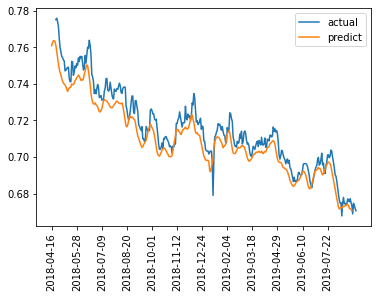

RMSE : 0.00730
MAE : 0.00598
after result:  rmse,mae 0.007296390481878543 0.005981149494945373
rmse_list_svm------------------------ [0.017037758876757868, 1.8298857037932832, 0.008885137620642483, 0.04112304477502783, 0.01141058527828195, 0.007296390481878543]
mae_list_svm------------------------ [0.01596586597664193, 1.748325544784948, 0.007681073730412137, 0.04019475348711377, 0.00972531698322326, 0.005981149494945373]
rmse_list_length 6
/content/drive/MyDrive/rate/eurusd2000_2019august_all.csv
---------------------------traindata_記述統計-------------------------------------------------------------
               High          Low        Close
count  4765.000000  4765.000000  4765.000000
mean      1.216274     1.221832     1.210633
std       0.172503     0.173137     0.171871
min       0.827600     0.832100     0.822800
25%       1.105000     1.111140     1.099670
50%       1.244800     1.250800     1.238500
75%       1.339500     1.344500     1.334200
max       1.599700     1.604000  

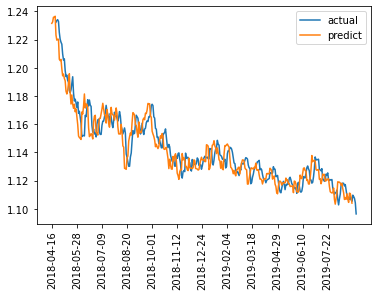

RMSE : 0.00444
MAE : 0.00336
after result:  rmse,mae 0.004438251083084091 0.003357363992756386
rmse_list_rf------------------------ [0.004438251083084091]
mae_list_rf------------------------ [0.003357363992756386]
rmse_list_length 1
/content/drive/MyDrive/rate/usdjpy2000_2019august_all.csv
---------------------------traindata_記述統計-------------------------------------------------------------
               High          Low        Close
count  4765.000000  4765.000000  4765.000000
mean    106.271742   106.751620   105.768978
std      13.775231    13.808399    13.733553
min      75.720000    76.000000    75.550000
25%      98.240000    98.850000    97.640000
50%     108.720000   109.182000   108.250000
75%     117.530000   117.960000   117.020000
max     134.780000   135.150000   134.100000
----------------------------testdata_記述統計-------------------------------------------------------
             High         Low       Close
count  365.00000  365.000000  365.000000
mean   110.30411  11

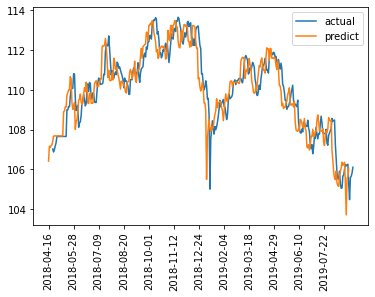

RMSE : 0.45212
MAE : 0.30372
after result:  rmse,mae 0.45211744295883705 0.303722316207782
rmse_list_rf------------------------ [0.004438251083084091, 0.45211744295883705]
mae_list_rf------------------------ [0.003357363992756386, 0.303722316207782]
rmse_list_length 2
/content/drive/MyDrive/rate/usdchf2000_2019august_all.csv
---------------------------traindata_記述統計-------------------------------------------------------------
               High          Low        Close
count  4765.000000  4765.000000  4765.000000
mean      1.164827     1.170758     1.159192
std       0.255012     0.256483     0.253664
min       0.718000     0.732300     0.708500
25%       0.962300     0.966600     0.957600
50%       1.084000     1.090000     1.076300
75%       1.284500     1.291700     1.277500
max       1.820300     1.829500     1.812800
----------------------------testdata_記述統計-------------------------------------------------------
              High         Low       Close
count  365.000000  365.0

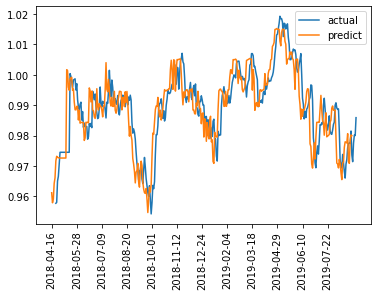

RMSE : 0.00378
MAE : 0.00284
after result:  rmse,mae 0.0037798430584820757 0.0028438808452439703
rmse_list_rf------------------------ [0.004438251083084091, 0.45211744295883705, 0.0037798430584820757]
mae_list_rf------------------------ [0.003357363992756386, 0.303722316207782, 0.0028438808452439703]
rmse_list_length 3
/content/drive/MyDrive/rate/gbpusd2000_2019august_all.csv
---------------------------traindata_記述統計-------------------------------------------------------------
               High         Low        Close
count  4765.000000  4765.00000  4765.000000
mean      1.615163     1.62185     1.608280
std       0.194189     0.19453     0.194032
min       1.205410     1.20853     1.152240
25%       1.482600     1.49300     1.474500
50%       1.587100     1.59190     1.580500
75%       1.745800     1.75300     1.738400
max       2.108500     2.11600     2.097400
----------------------------testdata_記述統計-------------------------------------------------------
              High      

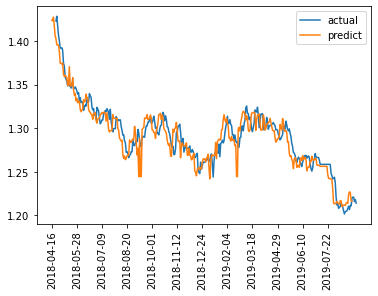

RMSE : 0.00901
MAE : 0.00586
after result:  rmse,mae 0.009006532134348292 0.005864131075839884
rmse_list_rf------------------------ [0.004438251083084091, 0.45211744295883705, 0.0037798430584820757, 0.009006532134348292]
mae_list_rf------------------------ [0.003357363992756386, 0.303722316207782, 0.0028438808452439703, 0.005864131075839884]
rmse_list_length 4
/content/drive/MyDrive/rate/usdcad2000_2019august_all.csv
---------------------------traindata_記述統計-------------------------------------------------------------
              High          Low        Close
count  4765.00000  4765.000000  4765.000000
mean      1.22207     1.227082     1.217288
std       0.18817     0.188324     0.188121
min       0.92290     0.930600     0.906100
25%       1.04730     1.051600     1.042000
50%       1.20680     1.213230     1.199770
75%       1.33849     1.343390     1.333300
max       1.61160     1.619400     1.611000
----------------------------testdata_記述統計--------------------------------------

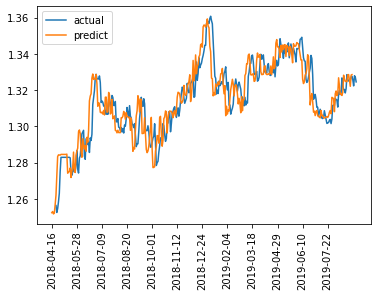

RMSE : 0.00490
MAE : 0.00377
after result:  rmse,mae 0.004904806673831482 0.0037724463788143376
rmse_list_rf------------------------ [0.004438251083084091, 0.45211744295883705, 0.0037798430584820757, 0.009006532134348292, 0.004904806673831482]
mae_list_rf------------------------ [0.003357363992756386, 0.303722316207782, 0.0028438808452439703, 0.005864131075839884, 0.0037724463788143376]
rmse_list_length 5
/content/drive/MyDrive/rate/audusd2000_2019august_all.csv
---------------------------traindata_記述統計-------------------------------------------------------------
               High          Low        Close
count  4765.000000  4765.000000  4765.000000
mean      0.786372     0.790534     0.781894
std       0.153709     0.154376     0.153002
min       0.483800     0.487200     0.478500
25%       0.702800     0.707200     0.698270
50%       0.769400     0.772700     0.765300
75%       0.907700     0.913600     0.902400
max       1.101800     1.108000     1.097700
------------------------

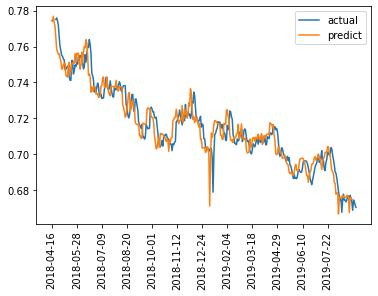

RMSE : 0.00403
MAE : 0.00288
after result:  rmse,mae 0.004032241874603414 0.002878771662639752
rmse_list_rf------------------------ [0.004438251083084091, 0.45211744295883705, 0.0037798430584820757, 0.009006532134348292, 0.004904806673831482, 0.004032241874603414]
mae_list_rf------------------------ [0.003357363992756386, 0.303722316207782, 0.0028438808452439703, 0.005864131075839884, 0.0037724463788143376, 0.002878771662639752]
rmse_list_length 6


In [ ]:
rmse_list_svm =[]
mae_list_svm = []
rmse_list_rf =[]
mae_list_rf = []
rmse_list_mlp_tanh=[]
mae_list_mlp_tanh =[]
rmse_list_mlp_relu=[]
mae_list_mlp_relu =[]
rmse_list_mlp_sigmoid=[]
mae_list_mlp_sigmoid =[]
model_list= ["MLP","RF","SVM"]
forex_list =[EURUSD,USDJPY,USDCHF,GBPUSD,USDCAD,AUDUSD]
forex_str =["EURUSD","USDJPY","USDCHF","GBPUSD","USDCAD","AUDUSD"]


#-----------MLP実行--------------------------------------------------------------------
for forex_csv in forex_list:
  print(forex_csv)
  rmse,mae= forex("MLP",forex_csv)
#---------------------------------------------------------------------------------------------------------------
#-----------SVM実行----------------------------------------------------------------------------------

for forex_csv in forex_list:
  print(forex_csv)
  rmse,mae = forex("SVM",forex_csv)

#--------------------------RF実行---------------------------------------------------------------------
for forex_csv in forex_list:
  print(forex_csv)
  rmse,mae = forex("RF",forex_csv)


In [ ]:
rmse_list_mlp_tanh

[0.008926197251179015,
 1.3334438533501833,
 0.006564235668753824,
 0.010149469477929326,
 0.010077553395044467,
 0.011344725483757104]

In [ ]:
table_rmse_mine = pd.DataFrame(index=["MLP_tanh","MLP_relu","MLP_sigmoid","RF","SVM"] , columns=["EURUSD","USDJPY","USDCHF","GBPUSD","USDCAD","AUDUSD"])
table_mae_mine = pd.DataFrame(index=["MLP_tanh","MLP_relu","MLP_sigmoid","RF","SVM"] , columns=["EURUSD","USDJPY","USDCHF","GBPUSD","USDCAD","AUDUSD"])

#----------------rmse_table-----------------
table_rmse_mine.loc["MLP_tanh"] = rmse_list_mlp_tanh
table_rmse_mine.loc["MLP_relu"] = rmse_list_mlp_relu
table_rmse_mine.loc["MLP_sigmoid"] = rmse_list_mlp_sigmoid
table_rmse_mine.loc["RF"] = rmse_list_rf
table_rmse_mine.loc["SVM"] = rmse_list_svm

#----------mae_tabel-------------------------
table_mae_mine.loc["MLP_tanh"] = mae_list_mlp_tanh
table_mae_mine.loc["MLP_relu"] = mae_list_mlp_relu
table_mae_mine.loc["MLP_sigmoid"] = mae_list_mlp_sigmoid
table_mae_mine.loc["RF"] = mae_list_rf
table_mae_mine.loc["SVM"] = mae_list_svm


table_rmse_mine


,EURUSD,USDJPY,USDCHF,GBPUSD,USDCAD,AUDUSD
MLP_tanh,0.0089262,1.33344,0.00656424,0.0101495,0.0100776,0.0113447
MLP_relu,0.0080971,0.556264,0.0137939,0.00975545,0.00941579,0.00511198
MLP_sigmoid,0.0191127,0.709749,0.00847953,0.0221166,0.00681615,0.0187445
RF,0.00443825,0.452117,0.00377984,0.00900653,0.00490481,0.00403224
SVM,0.0170378,1.82989,0.00888514,0.041123,0.0114106,0.00729639


In [ ]:
table_mae_mine

,EURUSD,USDJPY,USDCHF,GBPUSD,USDCAD,AUDUSD
MLP_tanh,0.00735449,1.15324,0.00540149,0.00842463,0.00886825,0.0101916
MLP_relu,0.00663396,0.430671,0.0122734,0.00811269,0.00759531,0.00393677
MLP_sigmoid,0.0179905,0.562924,0.0070881,0.0196096,0.00527704,0.0178622
RF,0.00335736,0.303722,0.00284388,0.00586413,0.00377245,0.00287877
SVM,0.0159659,1.74833,0.00768107,0.0401948,0.00972532,0.00598115


In [ ]:
table_rmse_absolute_error =table_rmse_paper - table_rmse_mine
table_mae_absolute_error =table_mae_paper - table_mae_mine

In [ ]:
#rmse
table_rmse_absolute_error["Mean_fixed_model"] = table_rmse_absolute_error.mean(axis='columns') # 行ごとの平均を求める
table_rmse_absolute_error.loc["Mean_fixed_forex"] = table_rmse_absolute_error.mean() # 列ごとの平均を求める
#mae
table_mae_absolute_error["Mean_fixed_model"] = table_mae_absolute_error.mean(axis='columns') # 行ごとの平均を求める
table_mae_absolute_error.loc["Mean_fixed_forex"] = table_mae_absolute_error.mean() # 列ごとの平均を求める
table_rmse_absolute_error

,EURUSD,USDJPY,USDCHF,GBPUSD,USDCAD,AUDUSD,Mean_fixed_model
MLP_tanh,0.0060738,-0.108644,0.00723576,0.0270505,0.0110224,0.00155527,-0.009284
MLP_relu,-0.0016971,0.414836,-0.00569393,0.0119446,-0.00281579,-0.000311984,0.069377
MLP_sigmoid,-0.0129127,0.427451,0.00952047,-0.00401659,0.000983851,-0.0107445,0.068380
RF,0.00236175,0.225983,0.00432016,0.0153935,0.00259519,0.00156776,0.042037
SVM,0.0161622,-1.19119,0.0305149,-0.00822304,0.00108941,0.0127036,-0.189823
Mean_fixed_forex,0.0019976,-0.0463121,0.00917947,0.00842978,0.00257502,0.000954023,-0.003863


In [ ]:
table_mae_absolute_error

,EURUSD,USDJPY,USDCHF,GBPUSD,USDCAD,AUDUSD,Mean_fixed_model
MLP_tanh,0.00464551,-0.177839,0.00359851,0.0161754,0.00873175,-0.000191585,-0.024147
MLP_relu,-0.00173396,0.319229,-0.0064734,0.00688731,-0.00239531,-0.000136766,0.052563
MLP_sigmoid,-0.0133905,0.338376,0.0085119,-0.00760958,0.00102296,-0.0109622,0.052658
RF,0.00194264,0.217178,0.00325612,0.00973587,0.00212755,0.00152123,0.039294
SVM,0.0144341,-1.27653,0.0299189,-0.0107948,0.000174683,0.0116189,-0.205196
Mean_fixed_forex,0.00117957,-0.115916,0.00776241,0.00287884,0.00193233,0.000369909,-0.016966


In [ ]:
table_rmse_absolute_error.to_csv("/content/drive/MyDrive/rate/table_rmse_absolute_error.csv")
table_mae_absolute_error.to_csv("/content/drive/MyDrive/rate/table_mae_absolute_error.csv")